Multi-Layer perceptron for parabolic dynamics prediction
---------------

This notebook loads the data generated from the pre-processing notebook and uses them to train and test a multi-layer perceptron for predicting the three parabolic coefficients that approximate the dynamics of the datasets melodic motifs.

This model and the results obtained are reported in:

    Ortega, F.J.M., Perez, A., Ramirez, R. Predicting dynamics in violin pieces with features from melodic motifs. In: Proceedings of the 12th International Workshop on Machine Learning and Music (MML2019). Würzburg, Germany. 2019.

#### Load and preprocess training data

In [9]:
import numpy as np
import pandas as pd

np.random.seed(1728)

def filter_outliers(df, cols=None, outlier_factor=5.):
    if cols is None:
        cols = (df.dtypes == 'float64') | (df.dtypes == 'int64')
    numdf = df.loc[:, cols]
    thold = outlier_factor * (numdf.quantile(0.75) - numdf.quantile(0.25))
    return df[((numdf - thold) < 0).all(axis=1)]


#  read csv
fhandle = open('data/allviolin.csv', 'r')
df = pd.read_csv(fhandle)
df.drop(['Unnamed: 0'], axis=1, inplace=True)
print('initial size: ' + str(len(df)))

# eliminate missing values, insufficient dynamics data (dynamicsX0 = -inf)
df.dropna()
df = df.loc[df.dynamicsX0 != -np.inf,:]

#  filter by motif size
df = df[df.numberOfNotes > 3]

print('size after N/A and small motif crop: ' + str(len(df)))

#  one-hot encode nominal values
for attrib in ['metricStrength', 'pieceMode', 'initalChord', 'finalChord']: #FIXME initalChord to initialChord
    df = pd.concat([df, pd.get_dummies(df[attrib], prefix=attrib)], axis=1)
    df.drop([attrib], axis=1, inplace=True)

#  shuffle rows
intact = df
df = df.sample(frac=1)
    
#  remove unused attributes
df = df.drop(['pieceId', 'motifId', 'pieceDynMean', 'pieceDynStd'], axis=1)

#  filter outliers/extreme values
df = filter_outliers(df, outlier_factor=10)
print('size w/o outliers: ' + str(len(df)))

#  standardize features
moments = np.zeros((3,2)) # output mean and std for reverting predictions
outs = df.loc[:,['dynamicsX2','dynamicsX1','dynamicsX0']]
moments[:,0] = outs.mean().to_numpy()
moments[:,1] = outs.std().to_numpy()
nums = df.loc[:,(df.dtypes == 'float64') | (df.dtypes == 'int64')]
df.loc[:, (df.dtypes == 'float64') | (df.dtypes == 'int64')] = (nums - nums.mean()) / nums.std()
        
        
#  split train/test
train = df.iloc[0:(len(df)*9)//10,:]
test = df.iloc[(len(df)*9)//10:,:]
print('lengths: {tr}, {t}'.format(tr=len(train), t=len(test)))


initial size: 12749
size after N/A and small motif crop: 10808
size w/o outliers: 10253
lengths: 9227, 1026


#### Define the neural network

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1728)
_, attrs = train.shape
attrs = attrs - 3 # 3 outputs
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(attrs, attrs//2 + 1)
        self.fc2 = nn.Linear(attrs//2 + 1, attrs//2 + 1)
        self.fc3 = nn.Linear(attrs//2 + 1, 3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(net.parameters(), lr=0.2, momentum=0.1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=600, gamma=0.1)

#### Train the model

In [ ]:
epochs = 1800
batch_size = 100
train_out = train.loc[:,['dynamicsX2','dynamicsX1','dynamicsX0']].to_numpy().astype('float64')
train_in = train.drop(['dynamicsX2','dynamicsX1','dynamicsX0'], axis=1).to_numpy().astype('float64')
train_np = np.concatenate((train_in, train_out), axis=1)
for t in range(epochs):
    np.random.shuffle(train_np)
    input_dt = torch.Tensor(train_np[:,:-3])
    truth = torch.Tensor(train_np[:,-3:])
    i = 0
    accloss = []
    accR = []
    while i < len(input_dt):
        if (i + batch_size < len(input_dt)):
            x = input_dt[i:i + batch_size,:]
            y = truth[i:i + batch_size,:]
        else:
            x = input_dt[i:,:]
            y = truth[i:,:]
        i = i + batch_size
        out = net(x)
        loss = loss_fn(out, y)
        net.zero_grad()
        loss.backward()
        optimizer.step()
        pred = out.detach().numpy()
        accloss.append(loss.item())
        accR.append(np.corrcoef(pred[:,0], y[:,0])[0,1])
    print('epoch: ' + str(t) + ' loss: ' + str(np.mean(accloss)) + '\tlr: ' + str(optimizer.param_groups[0]['lr']) + '\tr: {pr}'.format(pr=np.mean(accR)))
    scheduler.step()

#### Results

In [12]:
#  Compute correlation coefficients
test_in = test.drop(['dynamicsX2','dynamicsX1','dynamicsX0'], axis=1).to_numpy().astype('float64')

pred = net(torch.Tensor(test_in))
pred = pred.detach().numpy()
print('r0: {pr}'.format(pr=np.corrcoef(pred[:,0], test.dynamicsX2.to_numpy())[0][1]))
print('r1: {pr}'.format(pr=np.corrcoef(pred[:,1], test.dynamicsX1.to_numpy())[0][1]))
print('r2: {pr}'.format(pr=np.corrcoef(pred[:,2], test.dynamicsX0.to_numpy())[0][1]))

pred = net(torch.Tensor(train_in))
pred = pred.detach().numpy()
print('r0: {pr}'.format(pr=np.corrcoef(pred[:,0], train.dynamicsX2.to_numpy())[0][1]))
print('r1: {pr}'.format(pr=np.corrcoef(pred[:,1], train.dynamicsX1.to_numpy())[0][1]))
print('r2: {pr}'.format(pr=np.corrcoef(pred[:,2], train.dynamicsX0.to_numpy())[0][1]))

#  Save model
torch.save(net.state_dict(), open('results/mlp.pth', 'wb'))


r0: 0.23826428372827668
r1: 0.23747557915728126
r2: 0.21773401848174345
r0: 0.6818544148518239
r1: 0.7054418759015526
r2: 0.5222073806605737


In [13]:
#  Compute note-level error
offset = train.shape[0]
def resultForIndex(i, source=test):
    intact_idx = test.index[i]
    lvls = np.load('data/levels/' + str(intact.pieceId[intact_idx]) + 'lvls.npy') # all piece levels
    lvls = lvls[intact.motifId[intact_idx]] # this phrase levels
    x = np.linspace(0, 1, len(lvls))
    ytest = intact.dynamicsX2[intact_idx]*x**2 + intact.dynamicsX1[intact_idx]*x + intact.dynamicsX0[intact_idx]
    net_input = test.iloc[i, :].drop(['dynamicsX2','dynamicsX1','dynamicsX0']).to_numpy().astype('float64')
    pred = net(torch.Tensor(net_input))
    pred = pred.detach().numpy()
    y = (pred[0]*moments[0,1]+moments[0,0])*x**2 + (pred[1]*moments[1,1]+moments[1,0])*x + (pred[2]*moments[2,1]+moments[2,0])
    return (lvls, ytest, y)

   
s = 50 # pred.shape[0]
msePred = np.zeros((s,1))
mseIdeal = np.zeros((s,1))
mseLvl = np.zeros((s,1))
for i in range(s):
    lvls, ytest, y = resultForIndex(i)
    mseIdeal[i] = np.sum((ytest - lvls)**2)
    msePred[i] = np.sum((y - lvls)**2)
    mseLvl[i] = np.sum(np.asarray(lvls)**2)
    
print('Ideal approximation note-level RMS Error: ' + str(np.sqrt(np.mean(mseIdeal))))
print('Prediction note-level RMS Error: ' + str(np.sqrt(np.mean(msePred))))
print('Mean performance RMS loudness: ' + str(np.sqrt(np.mean(mseLvl))))

Ideal approximation note-level RMS Error: 1.6891970918706487
Prediction note-level RMS Error: 3.3900648195643193
Mean performance RMS loudness: 3.8577704937926085


[875, 64, 324]


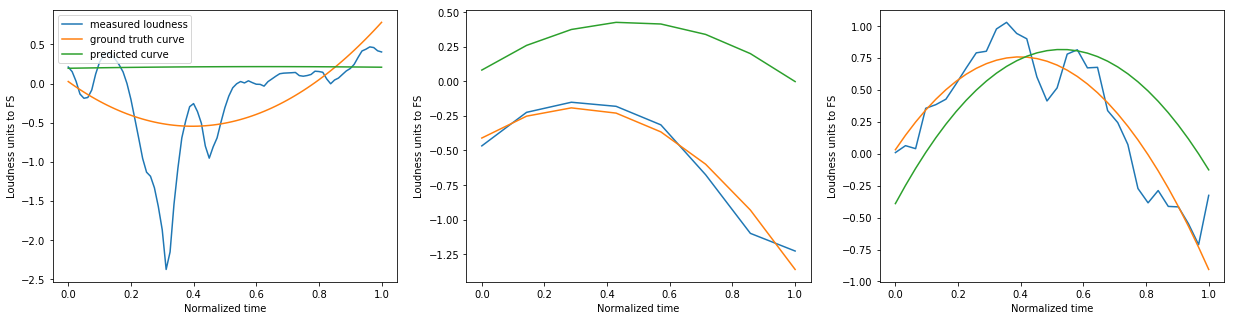

In [212]:
import random
import matplotlib.pyplot as plt

plt.figure(figsize=(21, 5))
indexes = random.sample(range(0,len(test)),3)
print(indexes)

plt.subplot(131)
lvls, ytest, y = resultForIndex(indexes[0])
x = np.linspace(0, 1, len(lvls))
coefs = np.polyfit(x, lvls, 2)

ycalc = coefs[0]*x**2 + coefs[1]*x + coefs[2]
plt.plot(x, lvls, label='measured loudness')
plt.plot(x, ytest, label='ground truth curve')
plt.plot(x, y, label='predicted curve')
plt.ylabel('Loudness units to FS')
plt.xlabel('Normalized time')
plt.legend(loc='upper left')

plt.subplot(132)
lvls, ytest, y = resultForIndex(indexes[1])
x = np.linspace(0, 1, len(lvls))
coefs = np.polyfit(x, lvls, 2)

ycalc = coefs[0]*x**2 + coefs[1]*x + coefs[2]
plt.plot(x, lvls, label='measured loudness')
plt.plot(x, ytest, label='ground truth curve')
plt.plot(x, y, label='predicted curve')
plt.ylabel('Loudness units to FS')
plt.xlabel('Normalized time')

plt.subplot(133)
lvls, ytest, y = resultForIndex(indexes[2])
x = np.linspace(0, 1, len(lvls))
coefs = np.polyfit(x, lvls, 2)

ycalc = coefs[0]*x**2 + coefs[1]*x + coefs[2]
plt.plot(x, lvls, label='measured loudness')
plt.plot(x, ytest, label='ground truth curve')
plt.plot(x, y, label='predicted curve')
plt.ylabel('Loudness units to FS')
plt.xlabel('Normalized time')

plt.savefig('results/result')
plt.show()